![nyc_cabs](nyc_cabs.jpg)

### Introduction 

For this project we are going to use Google BigQuery data to predict the estimated fare amount of New York taxi rides.
We aim to manipulate the dataset, prepare exploratory analysis, retreiving all the hidden patterns and variables relationships for creating machine learning models to offer expected fare.<br>
The major part is consentrated on data cleaning, visual component and fetaure engineering. 


#### The Data:

The data was collcted via Google BigQuery from "NYC TLC Trips" public dataset and contains information about NYC taxi trips details:

- Pickup longitude/latitude;
- Dropoff longitude/latitude;
- Pickup/dropoff time;
- Passenger count;
- Trip distance;
- Fare amount. 

We will retrieve 2015 year data and load 2 millions rows into dataframe. 

### Libraries import

In [13]:
import sys
!{sys.executable} -m pip install boto3

  Using cached https://files.pythonhosted.org/packages/b7/31/05c8d001f7f87f0f07289a5fc0fc3832e9a57f2dbd4d3b0fee70e0d51365/jmespath-0.9.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d7/14/2a0004d487464d120c9fb85313a75cd3d71a7506955be458eebfe19a6b1d/s3transfer-0.1.13-py2.py3-none-any.whl


In [16]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached https://files.pythonhosted.org/packages/1d/e7/5258cb787dc036f419ec57491decf8bfa89ab52c401b08b4b9228e43dc4c/xgboost-0.81-py2.py3-none-win_amd64.whl


In [2]:
"""
- gbq - load BigQuery data  
- pandas, matplotlib, numpy - for data manipulation 
- seaborn - data visualization

"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq
import boto3 # transfer file with data to S3 cloud 

%matplotlib inline

In [3]:
"""
- dateteme module for time type convertation  
- we will use math modules to derive the custom distance feature based on radians

"""
import datetime as dt
from math import sin, cos, sqrt, atan2, radians
from scipy import stats
from sklearn.utils import shuffle

In [4]:
"""
- import Plotly modules for interactive data visualization 
- connect to plot inside notebook

"""

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [5]:
"""
- sklearn for model building and performance validation

"""

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

### Data processing

In [6]:
"""
- loading data from big query project, write into frame 
- automatically upload csv file to S3 storage 

"""

df = gbq.read_gbq('SELECT * FROM taxi.taxi_fare_2015 LIMIT 2000000', project_id='XXXXXXX')
df.to_csv('fares_all.csv')

ACCESS_ID = 'XXXXXX'
ACCESS_KEY='XXXXXX'
filename = 'fares_all.csv'
bucket_name = 'storagebucketmachinelearning'


s3 = boto3.client('s3', aws_access_key_id=ACCESS_ID,
         aws_secret_access_key= ACCESS_KEY)
s3.upload_file(filename, bucket_name, filename)

ImportError: Load data from Google BigQuery

the pandas-gbq package is not installed
see the docs: https://pandas-gbq.readthedocs.io

you can install via pip or conda:
pip install pandas-gbq
conda install pandas-gbq -c conda-forge


In [29]:
df = pd.read_csv('fares_2015.csv')

In [30]:
cols=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
  'passenger_count', 'pickup_datetime', 'dropoff_datetime', 'fare_amount']

In [31]:
df=df[cols]

In [32]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,dropoff_datetime,fare_amount
0,-73.873169,40.774109,-74.016899,40.707699,1,2015-09-08 08:55:28,2015-09-08 09:50:12,44.5
1,-73.989334,40.741993,-73.945648,40.594944,1,2015-12-10 19:07:32,2015-12-10 19:59:46,61.5
2,-73.978577,40.756901,-74.183472,40.688156,1,2015-07-20 10:48:22,2015-07-20 11:25:50,66.0
3,-74.005569,40.706161,-74.177170,40.695053,1,2015-11-18 17:34:42,2015-11-18 18:36:35,70.5
4,-74.009438,40.706421,-74.046089,40.749378,1,2015-03-23 21:35:59,2015-03-23 21:58:38,50.0


In [33]:
"""
- drop rows with zero fare amount
- drop NaN values 

"""
df=df[df['fare_amount']>0]
df=df.dropna(how='any')
df.isna().any()

pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
pickup_datetime      False
dropoff_datetime     False
fare_amount          False
dtype: bool

In [34]:
"""
- apply the date type transformation for pickups/dropoffs

"""
df['pickup_datetime'] = df['pickup_datetime'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['dropoff_datetime'] = df['dropoff_datetime'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

Next we will calculate the difference in seconds and create a new column for taxi trips duration. 

In [35]:
"""
- convert the diff columns into 'float' type

"""
df['diff'] = df['dropoff_datetime'] - df['pickup_datetime']
df['diff'] = df['diff'].astype('timedelta64[s]')

In [36]:
df.dtypes

pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
fare_amount                 float64
diff                        float64
dtype: object

The further steps will be to derive time periods from stamps for both dropoffs and pickups.
These variables will be used for further hypothesis testing and models fitting.

In [37]:
"""
- create a separate column for each period of time, when dropoff/pickup was occured

"""
df['dropoff_year'] = [x.strftime('%Y')for x in df['dropoff_datetime']]
df['dropoff_month'] = [x.strftime('%m')for x in df['dropoff_datetime']]
df['dropoff_day'] = [x.strftime('%d')for x in df['dropoff_datetime']]
df['dropoff_hour'] = [x.strftime('%H')for x in df['dropoff_datetime']]


df['pickup_year'] = [x.strftime('%Y')for x in df['pickup_datetime']]
df['pickup_month'] = [x.strftime('%m')for x in df['pickup_datetime']]
df['pickup_day'] = [x.strftime('%d')for x in df['pickup_datetime']]
df['pickup_hour'] = [x.strftime('%H')for x in df['pickup_datetime']]

In [38]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,dropoff_datetime,fare_amount,diff,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,pickup_year,pickup_month,pickup_day,pickup_hour
0,-73.873169,40.774109,-74.016899,40.707699,1,2015-09-08 08:55:28,2015-09-08 09:50:12,44.5,3284.0,2015,09,08,09,2015,09,08,08
1,-73.989334,40.741993,-73.945648,40.594944,1,2015-12-10 19:07:32,2015-12-10 19:59:46,61.5,3134.0,2015,12,10,19,2015,12,10,19
2,-73.978577,40.756901,-74.183472,40.688156,1,2015-07-20 10:48:22,2015-07-20 11:25:50,66.0,2248.0,2015,07,20,11,2015,07,20,10
3,-74.005569,40.706161,-74.177170,40.695053,1,2015-11-18 17:34:42,2015-11-18 18:36:35,70.5,3713.0,2015,11,18,18,2015,11,18,17
4,-74.009438,40.706421,-74.046089,40.749378,1,2015-03-23 21:35:59,2015-03-23 21:58:38,50.0,1359.0,2015,03,23,21,2015,03,23,21


Here we see the enlarged dataframe by created time features. 
On the next step we continue data cleaning with outliers check. 

#### Checking dropoff/pickup coordinates outliers

Below we investigate the risk of incorrect spatial data - all coordinates pairs should be limited by boundaries: [-90, 90] for latitude and [-180, 180] for longitude.

In [39]:
"""
- initialize the interval for latitude/longitude
- check if dataframe contains values out of boundaries, display the length

"""

lat_range=[-90,90]
long_range=[-180,180]

# pickups check
print len(df[(df['pickup_latitude']> lat_range[0]) | (df['pickup_latitude']< lat_range[1])])
print len(df[(df['pickup_longitude']> long_range[0]) | (df['pickup_longitude']< long_range[1])])
# dropoffs check
print len(df[(df['dropoff_latitude']> lat_range[0]) | (df['dropoff_latitude']< lat_range[1])])
print len(df[(df['dropoff_longitude']> long_range[0]) | (df['dropoff_longitude']< long_range[1])])

1997130
1997130
1997130
1997130


All pairs of coordinates lies inside of corresponding intervals. Then, we can calculate the distance between points.

#### Finding the distance between pickups and dropoffs

To estimate the distance between dropoff point and pickup point we will apply Haversine formula based on radians and add related column to a dataframe. 

In [40]:
"""
- difine an approxiamte earth radius in km
- write a function to convert longitude/latitude to radians and return km distance from formula

"""

R=6373.0
def distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # estimate the distance between dropoff (lon2, lat2) and pickup (lon1, lat1)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [41]:
# adding a column to dataframe 
df['distance_trip'] = distance(df['pickup_longitude'], df['pickup_latitude'], 
                               df['dropoff_longitude'], df['dropoff_latitude'])

In [42]:
df.head() # check the results 

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime,dropoff_datetime,fare_amount,diff,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,pickup_year,pickup_month,pickup_day,pickup_hour,distance_trip
0,-73.873169,40.774109,-74.016899,40.707699,1,2015-09-08 08:55:28,2015-09-08 09:50:12,44.5,3284.0,2015,09,08,09,2015,09,08,08,14.174209
1,-73.989334,40.741993,-73.945648,40.594944,1,2015-12-10 19:07:32,2015-12-10 19:59:46,61.5,3134.0,2015,12,10,19,2015,12,10,19,16.750558
2,-73.978577,40.756901,-74.183472,40.688156,1,2015-07-20 10:48:22,2015-07-20 11:25:50,66.0,2248.0,2015,07,20,11,2015,07,20,10,18.871441
3,-74.005569,40.706161,-74.177170,40.695053,1,2015-11-18 17:34:42,2015-11-18 18:36:35,70.5,3713.0,2015,11,18,18,2015,11,18,17,14.509417
4,-74.009438,40.706421,-74.046089,40.749378,1,2015-03-23 21:35:59,2015-03-23 21:58:38,50.0,1359.0,2015,03,23,21,2015,03,23,21,5.684559


Apart from data correctness check the useful option will be to remove extreme points for distance, duration and fare amount variables.<br>
This operation will reduce the variance and take out potential outliers from data. 

#### Remove distance trip/ fare amount outliers 

In [43]:
"""
- we will use numpy .percentile function to calculate first and third quartile 
- next calculate interquartile interval 
- set up the boundaries for extremely small and large values 
- return the frame inside interval 

"""
def remove_outliers(df, column):
    quartile_1, quartile_3 = np.percentile(df[column], [25, 75])
    iqr = quartile_3 - quartile_1
    min = quartile_1 - (iqr * 1.5)
    max = quartile_3 + (iqr * 1.5)

    df = df[(df[column] <= max) & (df[column] >= min)]
    return df

In [44]:
"""
- apply function for duration, distance and fare amount 

"""
data=remove_outliers(df, 'distance_trip')
data=remove_outliers(data, 'fare_amount')
data=remove_outliers(data, 'diff')

The final note will be dropping the observetions where passengers count is more than 6. In this work we will consider the taxies that can carry up to 6 passangers only. 

In [46]:
data=data[data['passenger_count']<=6]

In [47]:
len(data)

1704730

In [49]:
data.to_csv('taxies.csv', encoding='utf-8')

In [7]:
data=pd.read_csv('taxies.csv', encoding='utf-8')

In [8]:
len(data)

1704730

### Explanatory data analysis

Before explanatory analysis start we list down a number of hypothesis as factors affecting the taxi rides cost:

1. Fare amount-distance trip relationship: the longer the distance the higher taxi fare to pay;
2. Trip duration effect: the trips with higher duration will cost more;
3. Pickup time period - high taxi fares for peak hours;
4. Pickup day - the fare amount can differ depends on day;
5. Pickup neighborhood - the fare amount can flactuate depending on location.

#### 1. Fare amount - distance trip

Starting with plotting distribution chart for distance and fare amount, we can investigate the form similar to stepwise and left tail for fare amount. However, the distribution peak reached between amount of 20 and 30.<br>
In comparison, distance distribution presented much smoother.

In [9]:
# set seaborn style with dark grid
plt.style.use('seaborn-darkgrid')

C:\Users\Refresh\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



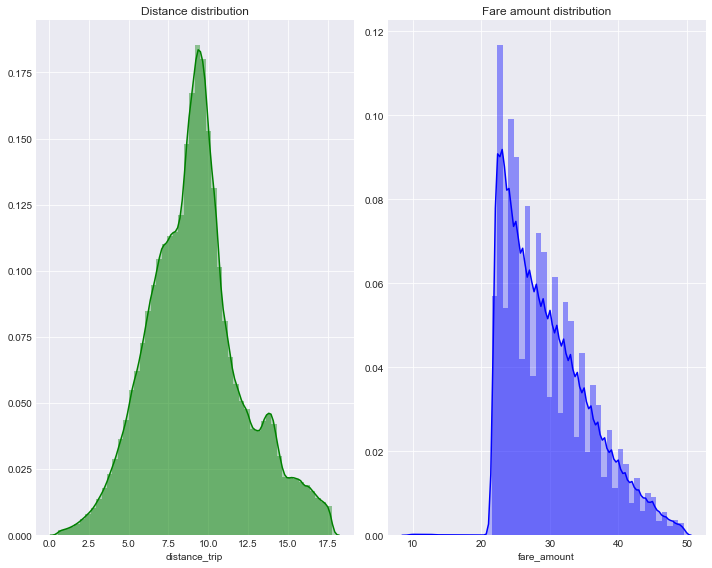

In [10]:
"""
- combine the distplots in one figure, customize the size

"""

f = plt.subplots(2,2,figsize=(10,8))
plt.subplot(1, 2, 1)
sns.distplot(data['distance_trip'], kde=True, color="g", kde_kws={"shade": True}, label = 'trip-distance')
plt.title('Distance distribution')

plt.subplot(1, 2, 2)
sns.distplot(data['fare_amount'], kde=True, color="b", kde_kws={"shade": True}, label = 'fare-amount')
plt.title('Fare amount distribution')


plt.tight_layout()

To illustrate relationship between variables graphically we draw a sample of 10000 points from entire frame.
The correlation between fare amount and distance seems considerable (0.67), the large number of points on scatter located along the main diagonal.

Pearson correlation: 0.67


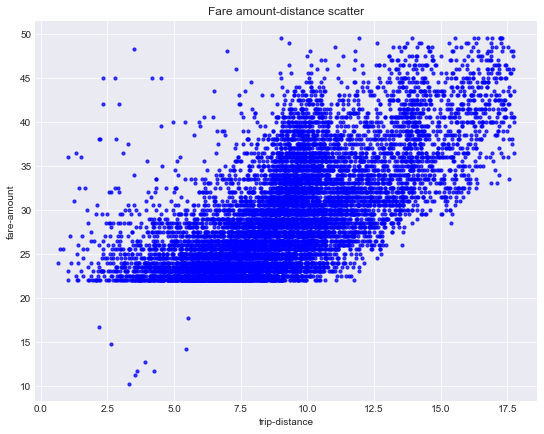

In [11]:
"""
- shuffle datframe, take the portion of 10000 rows
- use .corr() method to compute Pearson r for two variables in entire dataframe

"""

sample = shuffle(data)[0:10000]
# Create the plot object
fig, ax = plt.subplots(figsize=(9,7))

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
ax.scatter(sample['distance_trip'], sample['fare_amount'], s = 10, color = 'b', alpha = 0.75)


# Label the axes and provide a title
ax.set_title('Fare amount-distance scatter')
ax.set_xlabel('trip-distance')
ax.set_ylabel('fare-amount')
print 'Pearson correlation: '+ str(round(data['fare_amount'].corr(data['distance_trip']),2))

#### 2. Fare amount - duration

Duration trip distribution looks quite smooth and not significantly affected by outliers. Nonetheless the correlation between duration and fare amount is not such strong (0.51). 

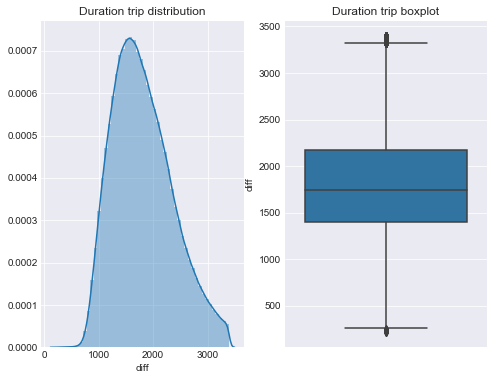

In [12]:
f = plt.subplots(2,2,figsize=(8,6))
plt.figure(1)
plt.subplot(121)
sns.distplot(data['diff'])
plt.title('Duration trip distribution')

# create seaborn boxplot 
plt.subplot(122)
sns.boxplot(y=data['diff'])
plt.title('Duration trip boxplot')

plt.show()

Pearson correlation: 0.51


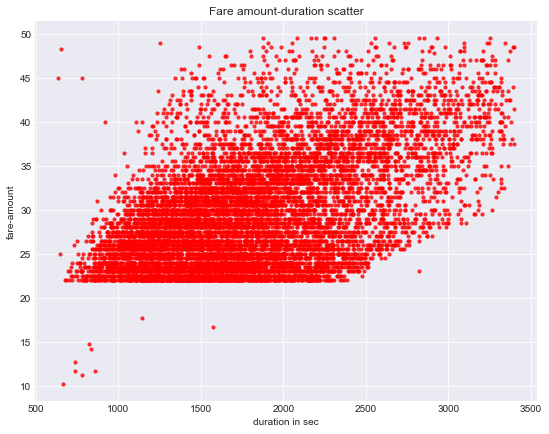

In [13]:
"""
- estimated Pearson R displayed lower correlation between fare and duration 

"""

fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(sample['diff'], sample['fare_amount'], s = 10, color = 'r', alpha = 0.75)

ax.set_title('Fare amount-duration scatter')
ax.set_xlabel('duration in sec')
ax.set_ylabel('fare-amount')
print 'Pearson correlation: '+ str(round(data['fare_amount'].corr(data['diff']),2))

#### 3. Time period effect

The further step will be to analyze the fare amount changes over the time. <br>
As we can observe from plot below, taxi costs remain stable on average over days. 

Text(0.5,1,'Mean fare amount per day')

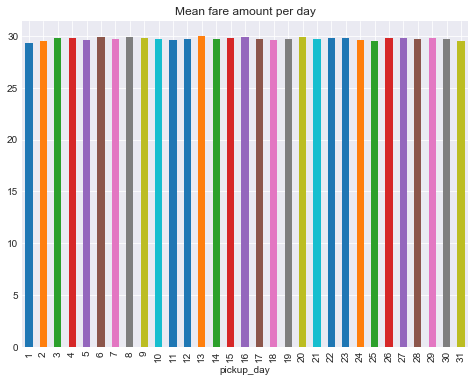

In [14]:
"""
- groupby data by pickup day and estimate the mean 

"""
fig, ax = plt.subplots(figsize=(8,6))
data.groupby('pickup_day')['fare_amount'].mean().plot.bar()
ax.set_title('Mean fare amount per day')

Over hours fare amount reaches its peak at 16:00 and slightly goes down till 21:00, while the lowest fare mean observed at 02:00. 

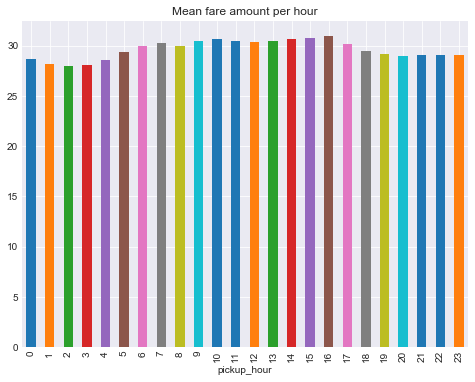

In [15]:
"""
- grouping per hour with mean estimated  

"""
fig, ax = plt.subplots(figsize=(8,6))

data.groupby('pickup_hour')['fare_amount'].mean().plot.bar()
ax.set_title('Mean fare amount per hour')

plt.show()

However, the total rides count per hour presents minumum between 3:00 and 5:00 and hits maximum at 22:00.

Text(0.5,1,'Trips count per hour')

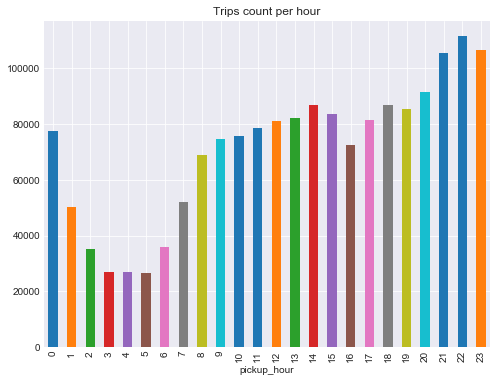

In [16]:
"""
- we use count() method to compute the total rides with respect of hour  

"""
fig, ax = plt.subplots(figsize=(8,6))
data.groupby('pickup_hour')['fare_amount'].count().plot.bar()
ax.set_title('Trips count per hour')

We countinue with correlations heatmap for numerical variables and find the highest rate is shown between distance and fare amount (same result calculated previously). For other variables correlation seems not significant. 

#### 4. Plotting Heatmap 

In [17]:
# list numerical variables
numeric=['dropoff_longitude','dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 
         'distance_trip', 'diff', 'fare_amount']

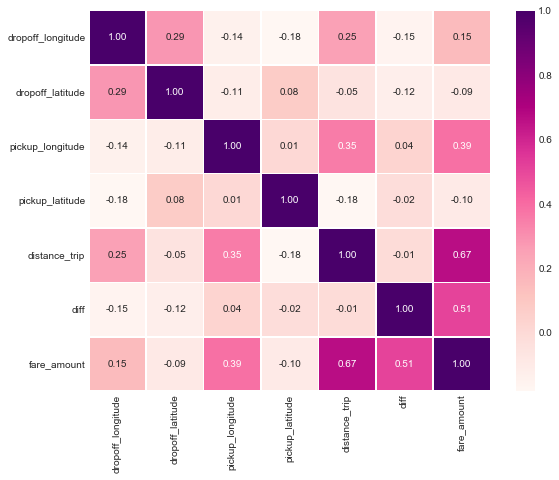

In [18]:
"""
- compute correlation matrix 
- plot heatmap annotated with color bar

"""

matrix = data[numeric].corr()
y, x = plt.subplots(figsize=(9, 7))

sns.heatmap(matrix, annot=True, fmt=".2f", linewidths=.5, cmap='RdPu')
plt.show()

Additionaly we will build scatter plots to display the dense area for pickups and dropoffs. Besides we want to highlight the pickup points where fare amount flactuates over locations. 

#### 5. Pickups/dropoffs location

Text(0,0.5,'latitude')

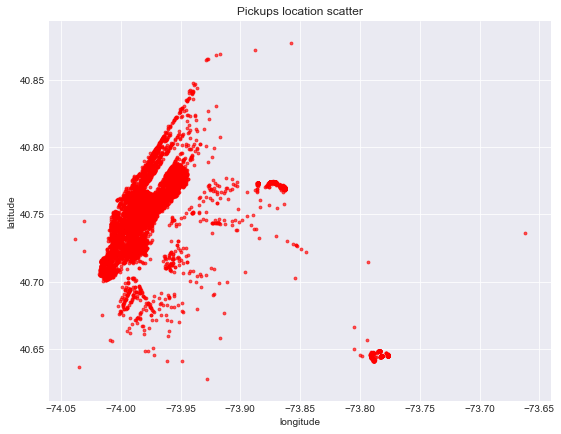

In [19]:
"""
- show the scatter based on pickups latitude/longitude

"""
fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(sample['pickup_longitude'], sample['pickup_latitude'], s = 8, color = 'r', alpha = 0.65)


ax.set_title('Pickups location scatter')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

Text(0,0.5,'latitude')

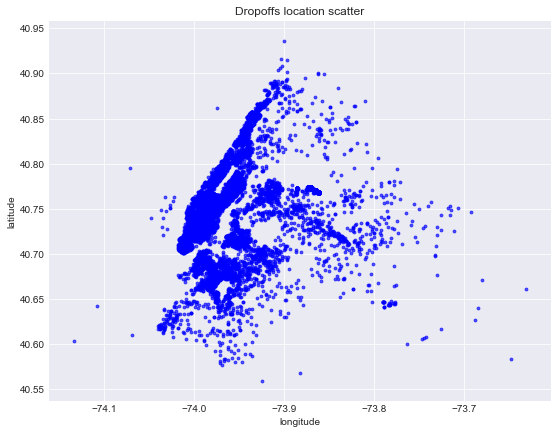

In [20]:
"""
- show the scatter based on dropoffs latitude/longitude

"""
fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(sample['dropoff_longitude'], sample['dropoff_latitude'], s = 8, color = 'b', alpha = 0.65)


# Label the axes and provide a title
ax.set_title('Dropoffs location scatter')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

Chart shows highest density area approximately between -74.05, -73.05 in tems of longitude and 40.70, 40.85 latitudes.
The fare amount varies over the scatter, but anyhow it tends to increase on the range from 40.55 to 40.65 latitudes. 

Text(0,0.5,'latitude')

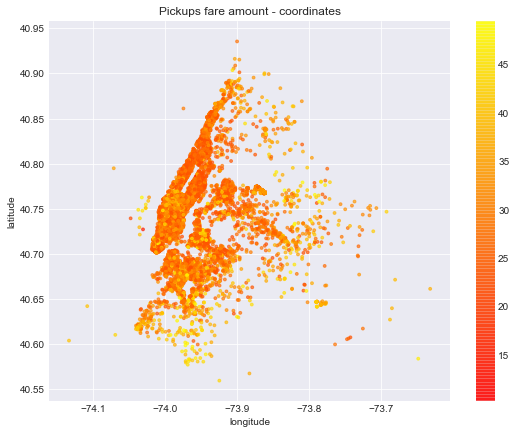

In [21]:
"""
- use 'c' argument to add plot annotation,
- color bar shows gradation with respect of fare change  

"""

fig, ax = plt.subplots(figsize=(9,7))

scatter = ax.scatter(sample['dropoff_longitude'], sample['dropoff_latitude'], c=sample['fare_amount'],
           s = 8, alpha = 0.65, cmap=plt.cm.autumn)
plt.colorbar(scatter)

ax.set_title('Pickups fare amount - coordinates')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

To provide the interactive visibility we are going to map points using Mapbox tool and Plotly modules.<br>
In this case we need to access custom mapbox style with access token and style reference. 

In [22]:
"""
- first we get token and map style reference
- generate mapping data from shuffled frame

"""
map_access_token='pk.eyJ1IjoibWFrYXJvdmFydHlvbSIsImEiOiJjamxvdXB4bXMxeGhzM3BzNnk2dG9zb3YzIn0.BhSxhXt27-1c5S-s1VLhkQ'
map_style='mapbox://styles/makarovartyom/cjqaxjdas29rd2smyjhd76mqf'
map_data= shuffle(data)[0:10000]

In [23]:
"""
- using go module to plot coordinates 
- choose custom layout - NYC map with center point
- use iplot() modul to display the figure 

"""
mapping = [go.Scattermapbox(
            lat= map_data['pickup_latitude'] ,
            lon= map_data['pickup_longitude'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'rgb(17, 157, 255)',
                opacity = 1.0
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=map_access_token,
                                bearing=10,
                                pitch=60,
                                zoom=12,
                                center= dict(
                                         lat=40.761,
                                         lon=-73.936),
                                style= "mapbox://styles/makarovartyom/cjqfhii65ipy92rojkbe0ucxr"),
                    width=900,
                    height=600, title = "NYC Pickups locations")
fig = dict(data=mapping, layout=layout)
iplot(fig)

In [24]:
"""
- mapping for dropoffs using same layout

"""

mapping = [go.Scattermapbox(
            lat= map_data['dropoff_latitude'] ,
            lon= map_data['dropoff_longitude'],
            mode='markers',
            marker=dict(
                size= 4,
                color = 'rgb(215, 48, 39)',
                opacity = 1.0
            ),
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=map_access_token,
                                bearing=10,
                                pitch=60,
                                zoom=12,
                                center= dict(
                                         lat=40.761,
                                         lon=-73.936),
                                style= "mapbox://styles/makarovartyom/cjqfhii65ipy92rojkbe0ucxr",
                               ),
                    width=900,
                    height=600, title = "NYC Dropoffs locations")
fig = dict(data=mapping, layout=layout)
iplot(fig)

The busiest taxi traffic covers Manhattan district center and goes down across Brooklyn and Queens. 

### Model preparation

In the next phase we are working on regression problem to build a predictive model for taxi fares.<br>
To derive percise predictions we will take different algorithms into consideration:

1. Multiple regresssion with regularization component(L1/L2);
2. Random forest model;
3. XGBoost model.
    

#### 1.1 Linear model without regularization 

We start with spliting data on train-validation and test. Using 10% of data as test sample we train basic linear model and estimate performance metrics - MAE (mean absolute error) and RMSE (root squared error) on test. 

In [104]:
"""
- perform train_test_split() mudule for data split
- separate the  relevant features list and target as an output 

"""
train_valid_data, test_data = train_test_split(data, test_size=0.1)

features=['dropoff_longitude','dropoff_latitude', 'pickup_longitude', 'pickup_latitude', 
         'distance_trip', 'diff', 'passenger_count', 'dropoff_month', 'dropoff_day', 'dropoff_hour',
         'pickup_month', 'pickup_day', 'pickup_hour']
output='fare_amount'

In [105]:
"""
- define the function to compute errors 
- print the result on test data

"""

def compute_error(predictions, true_values):
    resid=true_values-predictions
    rss = sum(resid*resid)
    # computing root mean absolute error 
    mae_true=sum(abs(resid))/len(predictions)
    # computing root mean squared error 
    mse_true=rss/len(resid)
    rmse_true=np.sqrt(mse_true)
    
    print "RMSE on test equals "+ "{:.{}f}".format( rmse_true, 2 )
    print "MAE on test  equals "+"{:.{}f}".format( mae_true, 2 )  

In [106]:
"""
- create a linear regression object
- fit with train-validation data
- make predictions on test

"""
linear=LinearRegression(normalize=True)
linear.fit(train_valid_data[features], train_valid_data[output])
predictions=linear.predict(test_data[features])
compute_error(predictions, test_data[output])

RMSE on test equals 3.09
MAE on test  equals 2.31


#### 1.2 Ridge regression

Next we will use train-validation data to build regression model with L2 regularization, performing k-folds cross validation to tune regularization parameter. <br>
For each fold we train a model and compute mean squared and root mean squared errors to find mean across folds. 
Besides we are going to visualize the mean absolute error change with respect of penalty parameter value.

In [107]:
"""
- use number of folds k=10  
- display folds boundaries for train-validation data

"""

n = len(train_valid_data) # will use entire frame
k=10
# print boundaries for each fold 
for fold in range(k):
    start = (n*fold)/k 
    end = (n*(fold+1))/k-1
    print fold, (start, end)

0 (0, 153424)
1 (153425, 306850)
2 (306851, 460276)
3 (460277, 613701)
4 (613702, 767127)
5 (767128, 920553)
6 (920554, 1073978)
7 (1073979, 1227404)
8 (1227405, 1380830)
9 (1380831, 1534256)


In [108]:
"""
- initialize the list of penalty values and starting points: split on train/validation, 
compute error for each fold, sum it up and estimate the average error for particular penalty 

"""

l2_penalty=[1e-17, 1e-12, 1e-06, 0.001, 0.01, 1, 2]
mae_sum = 0
rmse_sum = 0
mae_penalty=[]
# iterate through penalty values, create Ridge object 
for alpha in l2_penalty:
    ridge=linear_model.Ridge(alpha=alpha, normalize=True)
    for i in xrange(k):
        start=(n*i)/k
        end=(n*(i+1))/k-1
        valid=train_valid_data[start:end+1]
        training=train_valid_data[0:start].append(train_valid_data[end+1:n])
        # fitting model, making predictions 
        ridge.fit(training[features], training[output])
        predictions=ridge.predict(valid[features])
        resid=valid[output]-predictions
        # computing rss
        fold_rss = sum(resid*resid)
        # computing mean absolute error 
        fold_mae=sum(abs(resid))/len(predictions)
        mae_sum+=fold_mae
        # computing root mean squared error 
        fold_mse=fold_rss/len(resid)
        fold_rmse=np.sqrt(fold_mse)
        rmse_sum+=fold_rmse
    # estimate validation errors for each alpha 
    val_mae = mae_sum/k
    val_rmse = rmse_sum/k 
    mae_penalty.append(val_mae)
    print "RMSE for alpha=" +str(alpha)+' equals '+ "{:.{}f}".format( val_rmse, 2 )
    print "MAE for alpha="+str(alpha)+' equals '+"{:.{}f}".format( val_mae, 2 )


RMSE for alpha=1e-17 equals 3.08
MAE for alpha=1e-17 equals 2.31
RMSE for alpha=1e-12 equals 6.16
MAE for alpha=1e-12 equals 4.62
RMSE for alpha=1e-06 equals 9.25
MAE for alpha=1e-06 equals 6.94
RMSE for alpha=0.001 equals 12.33
MAE for alpha=0.001 equals 9.25
RMSE for alpha=0.01 equals 15.41
MAE for alpha=0.01 equals 11.56
RMSE for alpha=1 equals 19.38
MAE for alpha=1 equals 14.71
RMSE for alpha=2 equals 23.97
MAE for alpha=2 equals 18.40


Plot below presents the mean absolute error increases with respect of penalty rate growth. 
The best choice will be to fit model with a small alpha value to avoid underfitting.  

Text(0,0.5,'Mean absolute error')

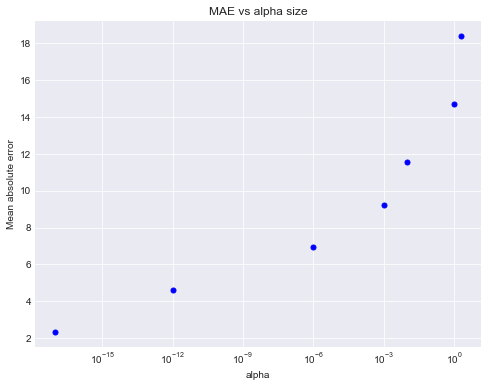

In [109]:
fig, ax = plt.subplots(figsize=(8,6))
# plot log-scale x-axis  for alpha values 
plt.plot(l2_penalty, mae_penalty,'b.', markersize=10)
plt.xscale('log')
ax.set_title('MAE vs alpha size')
ax.set_xlabel('alpha')
ax.set_ylabel('Mean absolute error')

Make predictions on test data with alpha=1e-17, compute metrics. Since alpha value is quite small, penalization effect will be insignificant and ridge solution will have the same performance as in case of least squares method. 

In [110]:
"""
- fitting model with best penalty size 
- compute metrics on test

"""

# fitting model with best penaty size
# making predictions on test data

ridge_best=linear_model.Ridge(alpha=1e-17, normalize=True)
ridge_best.fit(train_valid_data[features], train_valid_data[output])
predictions=ridge_best.predict(test_data[features])
compute_error(predictions, test_data[output])

RMSE on test equals 3.09
MAE on test  equals 2.31


Dispay coefficients of trained models with related features.

In [111]:
print 'Coefficients for Ridge model:'
list(zip(features, ridge_best.coef_))

Coefficients for Ridge model:


[('dropoff_longitude', 13.746485346237028),
 ('dropoff_latitude', -1.9785659535408673),
 ('pickup_longitude', 18.380286796131795),
 ('pickup_latitude', 7.9433914587991294),
 ('distance_trip', 1.2030381728895094),
 ('diff', 0.005996068446945504),
 ('passenger_count', 0.01320418289666157),
 ('dropoff_month', -0.0730569948345626),
 ('dropoff_day', -0.0008093100912625868),
 ('dropoff_hour', -0.012998954674863459),
 ('pickup_month', 0.0710559386964765),
 ('pickup_day', 0.0015239426868624557),
 ('pickup_hour', -0.02979919798641634)]

In [112]:
print 'Coefficients for Linear model:'
list(zip(features, linear.coef_))

Coefficients for Linear model:


[('dropoff_longitude', 13.74648534623664),
 ('dropoff_latitude', -1.9785659535408147),
 ('pickup_longitude', 18.38028679613121),
 ('pickup_latitude', 7.943391458799528),
 ('distance_trip', 1.2030381728895283),
 ('diff', 0.005996068446945507),
 ('passenger_count', 0.013204182896661905),
 ('dropoff_month', -0.07305699483418675),
 ('dropoff_day', -0.0008093100912548736),
 ('dropoff_hour', -0.01299895467486222),
 ('pickup_month', 0.0710559386961001),
 ('pickup_day', 0.0015239426868548216),
 ('pickup_hour', -0.02979919798641745)]

#### 1.3 Lasso regression

Perform the same process for Lasso regression, tuning the parameters with 10-folds cross-validation. 

In [113]:
# use higher alpha values for L1 regularization 
l1_penalty = [1e-7, 1e-5, 1e-3, 1e-2, 1e-1, 1, 5]
n = len(train_valid_data)
k=10
mae_sum=0
rmse_sum=0
mae_penalty=[]

In [114]:
"""
- train Lasso model, specifying maximum iteration=1e5
- split by train and valid data sets, compute validation metrics

"""

for alpha in l1_penalty:
    lasso=Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    for i in xrange(k):
        start=(n*i)/k
        end=(n*(i+1))/k-1
        valid=train_valid_data[start:end+1]
        training=train_valid_data[0:start].append(train_valid_data[end+1:n])
        # fitting model, making predictions 
        lasso.fit(training[features], training[output])
        predictions=lasso.predict(valid[features])
        resid=valid[output]-predictions
        # computing rss
        fold_rss = sum(resid*resid)
        # computing mean absolute error 
        fold_mae=sum(abs(resid))/len(predictions)
        mae_sum+=fold_mae
        # computing root mean squared error 
        fold_mse=fold_rss/len(resid)
        fold_rmse=np.sqrt(fold_mse)
        rmse_sum+=fold_rmse
    val_mae = mae_sum/k
    val_rmse = rmse_sum/k 
    mae_penalty.append(val_mae)
    print "RMSE for alpha=" +str(alpha)+' equals '+ "{:.{}f}".format( val_rmse, 2 )
    print "MAE for alpha="+str(alpha)+' equals '+"{:.{}f}".format( val_mae, 2 )

RMSE for alpha=1e-07 equals 3.08
MAE for alpha=1e-07 equals 2.31
RMSE for alpha=1e-05 equals 6.16
MAE for alpha=1e-05 equals 4.63
RMSE for alpha=0.001 equals 9.83
MAE for alpha=0.001 equals 7.50
RMSE for alpha=0.01 equals 16.01
MAE for alpha=0.01 equals 12.56
RMSE for alpha=0.1 equals 22.18
MAE for alpha=0.1 equals 17.62
RMSE for alpha=1 equals 28.36
MAE for alpha=1 equals 22.68
RMSE for alpha=5 equals 34.54
MAE for alpha=5 equals 27.74


L1 had considerable effect on model performance, adding sum of the absolute value of the coefficients as a penalty term. 

Text(0,0.5,'Mean absolute error')

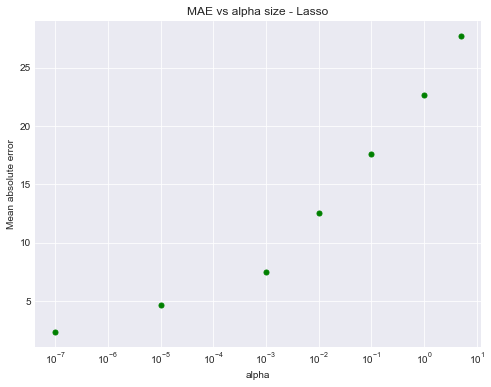

In [115]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(l1_penalty, mae_penalty,'g.', markersize=10)
plt.xscale('log')
ax.set_title('MAE vs alpha size - Lasso')
ax.set_xlabel('alpha')
ax.set_ylabel('Mean absolute error')

In [116]:
lasso=Lasso(alpha=1e-7,normalize=True, max_iter=1e5)
lasso.fit(train_valid_data[features], train_valid_data[output])
predictions=lasso.predict(test_data[features])

compute_error(predictions, test_data[output])

RMSE on test equals 3.09
MAE on test  equals 2.31


We observe the same fact of underfitting for Lasso regression, hence the better approach is to process with a small regularization term.

#### 2.1 Random Forest model

To train higher performance models for predictions, we contunue with applying non-parametric algorithms. <br>
In this case we will learn functional relationships from data, not making strong assumptions about function's form.

Strating with Randon Forest regression algorithm, built a model with specified trees and minimum leaf samples parameters.

In [10]:
"""
- n_estimators=100 - computation using 100 trees in model
- samples in leaf node=5
- make predictions and compute same metrics

"""
rf_reg = RandomForestRegressor(random_state = 123, n_estimators=100, n_jobs=-1, min_samples_leaf =5)
rf_reg.fit(train_valid_data[features], train_valid_data[output])

predictions=rf_reg.predict(test_data[features])
compute_error(predictions, test_data[output])

RMSE on test equals 2.05
MAE on test  equals 1.41


To learn the features importance of the trained model, we are able to call *feature_importances_* function below:

In [51]:
"""
- use argsort function() to sort per importance rate
- plot importance rate wih related features

"""
def display_importance(model):
    importance_list=[]
    feat_list=[]
    importance = model.feature_importances_
    feature_indices = importance.argsort()
    for index in feature_indices: 
        importance_list.append(round(importance[index] *100.0,2))
        feat_list.append(features[index])
    imp=pd.DataFrame({'feature': feat_list, 'importance': importance_list})
    data = [go.Bar(
            x=imp['feature'],
            y=imp['importance'])
       ]
    layout = go.Layout(title='Features importance, %')
    fig = dict(data=data, layout=layout)
    iplot(fig)
    return imp

In [52]:
# apply function to display results
display_importance(rf_reg)

,feature,importance
0,passenger_count,0.13
1,dropoff_month,0.27
2,dropoff_day,0.28
3,pickup_month,0.29
4,pickup_day,0.44
5,dropoff_hour,0.68
6,pickup_hour,0.82
7,pickup_latitude,1.84
8,pickup_longitude,3.97
9,dropoff_longitude,4.65


Seems that trip distance and trip duration provide the highest importance contribution to overall performance, while the features like passenger count and time attributes shown unsignificant. 

#### 2.2 XGBoost model

Finally, we apply Gradient boosing algorithm to perform desicion trees ensemble approach and present the features importance the same as in random forest case.

In [73]:
xgboost_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.07, eta=1, 
                               eval_metric = 'rmse', max_depth=10)

In [74]:
xgboost_reg.fit(train_valid_data[features], train_valid_data[output])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, eval_metric='rmse', gamma=0,
       learning_rate=0.07, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [75]:
predictions=xgboost_reg.predict(test_data[features])
compute_error(predictions, test_data[output])

RMSE on test equals 2.05
MAE on test  equals 1.45


In [76]:
# apply function to display results for XGboost
display_importance(xgboost_reg)

,feature,importance
0,pickup_month,0.19
1,pickup_day,0.59
2,passenger_count,0.79
3,dropoff_month,2.67
4,dropoff_day,2.95
5,pickup_hour,4.45
6,dropoff_hour,4.66
7,diff,9.33
8,distance_trip,9.51
9,pickup_latitude,11.93


With XGboost model fitting dropoff coordinte features dominate the others in contrast with random forest model. 
However, we assume the different options for XGboost to measure features importance.<br>
The chart below represents different order of features importance in terms of type: 
- **"weight"**: by number of times feature used to split data across the trees;
- **"cover"**: number of times feature used to split data across the trees, but wighted by training data points;
- **"gain"**: by average training loss reduction of feature use for split. 

The best importance measure choice generally relies on model consistency and ability to miinimize the error. 

Text(0.5,1,'Feature importance - "gain" measure')

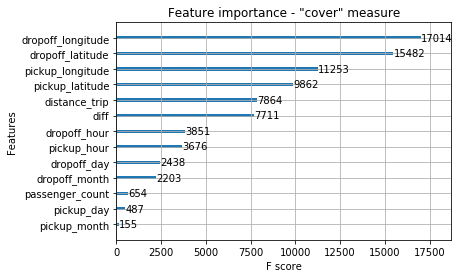

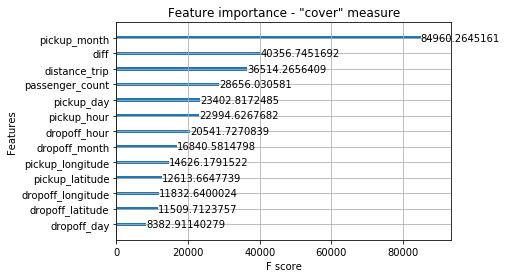

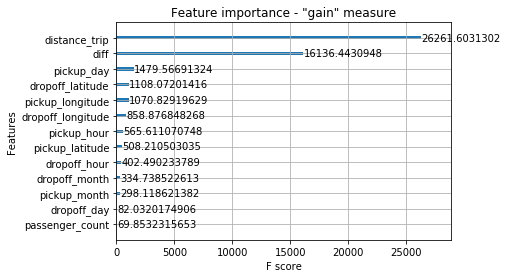

In [77]:
# plot importance based on 'weight' measure
xgb.plot_importance(xgboost_reg, importance_type='weight')
plt.title('Feature importance - "cover" measure')
# based on 'cover' measure
xgb.plot_importance(xgboost_reg, importance_type='cover')
plt.title('Feature importance - "cover" measure')
# based on 'gain' measure
xgb.plot_importance(xgboost_reg, importance_type='gain')
plt.title('Feature importance - "gain" measure')

### Results and models comparison

In [139]:
results=pd.DataFrame({'model':['Linear regression', 'Ridge regression', 'Lasso regression',
                              'Random Forest', 'XGBoost regressor'],
                     'RMSE':[3.09, 3.09, 3.09, 2.05, 2.05],
                     'MAE':[2.31, 2.31, 2.31, 1.41, 1.45]})

In [142]:
trace0 = go.Table(
  header = dict(
    values = list(results.columns[::-1]),
    line = dict(color = '#506784'),
    fill = dict(color =  '#b8b894'),
    align = ['left','center', 'center'],
    font = dict(color = 'white', size = 12)
  ),
  cells = dict(
    values = [results['model'], results['RMSE'], results['MAE'] 
             ],
    line = dict(color = '#506784'),
    fill = dict(color =  '#e0e0d1'),
    align = ['left', 'center', 'center'],
    font = dict(color = '#506784', size = 11)
    ))

data = [trace0]
iplot(data)

In terms of RMSE measurement we see Random Forest and XGBoost models obtain the same results and reduce the fare of amount error prediction to 2.05. However, the further tunning models on search grid potentially can lead even to a higher result. <br>
Estimated RMSE with linear model fitting approaches higher value (3.09) and gives a better result with small regularization parameter. 
Besides, in terms of "bias-variance" tradeoff it's worth montioning the difference between RF and XGBoost approches. <br>
While boosted trees tend to reduce bias and decreasing a generalization error, combining weak high-biased learners, RF in opposite, grows low-biased trees and minimizes the error by variance reduction.